In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import font_manager, rc
font_path= 'C:/Windows/Fonts/NGULIM.TTF'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

#### 통합 데이터 불러오기

In [3]:
df = pd.read_csv('../data_2/cow_체고0제거.csv') 
df.head()

,개월령,생시체중,근내평균,도체범위근내평균,체고,체장,형매도축수,형매도체평균,형매근내평균,형매근내평균가산,6개월내출산,농가근내평균,농가근내평균가산,근내EPD,근내,점수,농가구분,TARGET1
0,46,644.64,3.34,3.23,131.4,158.9,NaN,NaN,NaN,NaN,N,4.16,-1.05,0.18,6,4,농가소,0
1,46,633.93,4.59,4.52,129.7,148.4,NaN,NaN,NaN,NaN,Y,4.16,-1.05,0.17,4,3,농가소,0
2,32,567.86,5.50,4.89,130.3,158.0,NaN,NaN,NaN,NaN,N,5.58,0.53,0.42,7,5,농가소,1
3,33,564.29,6.13,5.56,130.7,155.9,NaN,NaN,NaN,NaN,Y,3.78,-0.91,0.42,2,2,농가소,0
4,48,692.86,4.79,4.61,131.2,146.1,NaN,NaN,NaN,NaN,Y,3.90,-1.35,0.82,4,3,농가소,0


In [4]:
df_copy = df.copy()
print(df_copy.shape)
df_copy.head(1)

(99848, 18)


,개월령,생시체중,근내평균,도체범위근내평균,체고,체장,형매도축수,형매도체평균,형매근내평균,형매근내평균가산,6개월내출산,농가근내평균,농가근내평균가산,근내EPD,근내,점수,농가구분,TARGET1
0,46,644.64,3.34,3.23,131.4,158.9,NaN,NaN,NaN,NaN,N,4.16,-1.05,0.18,6,4,농가소,0


##### 로지스틱 반복문, 다변량

In [5]:
df_copy.columns = ['개월령', '생시체중', '근내평균', '도체범위근내평균', '체고', '체장', '형매도축수', '형매도체평균',
       '형매근내평균', '형매근내평균가산', '출산여부_6개월내', '농가근내평균', '농가근내평균가산', '근내EPD', '근내',
       '점수', '농가구분', 'TARGET1']

##### train_test_split 7:3

In [6]:
from sklearn.model_selection import train_test_split

X = df_copy.drop(['TARGET1'],axis=1)
Y = df_copy.TARGET1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 2023)

print(f'데이터 셋 70%:{df_copy.shape[0]*0.7}')
print(f'데이터 셋 30%:{df_copy.shape[0]*0.3}')

train = pd.concat([X_train,Y_train], axis=1)
test = pd.concat([X_test,Y_test], axis=1)

print(f'train set:{train.shape[0]}')
print(f'test set:{test.shape[0]}')

데이터 셋 70%:69893.59999999999
데이터 셋 30%:29954.399999999998
train set:69893
test set:29955


##### train data set, 결측치 처리 전 logistic 결과

In [8]:
model = sm.Logit.from_formula(""" TARGET1 ~ 개월령+ 생시체중+ 
근내평균+도체범위근내평균+체고+체장+형매도축수+형매도체평균+
형매근내평균+형매근내평균가산+C(출산여부_6개월내)
+농가근내평균+농가근내평균가산+근내EPD
+C(농가구분) """, train).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.289893
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                TARGET1   No. Observations:                14627
Model:                          Logit   Df Residuals:                    14611
Method:                           MLE   Df Model:                           15
Date:                Sun, 22 Oct 2023   Pseudo R-squ.:                  0.1951
Time:                        19:57:26   Log-Likelihood:                -4240.3
converged:                       True   LL-Null:                       -5268.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -5.7169      1.613     -3.545      0.000      -8.878      -2.556
C(출산여부_6개월내)[T.Y]    -0.3868      0.076     -5.108      0.000      -0.535      -0.238
C(농가구분)[T.우시장소]       0.5666      0.107      5.286      0.000       0.357       0.777
개월령                   0.0020      0.004      0.474      0.635      -0.006       0.010
생시체중                  0.0013      0.000      2.712      0.007       0.000       0.002
근내평균                  0.1746      0.080      2.186      0.029       0.018       0.331
도체범위근내평균              0.7855      0.060     13.114      0.000       0.668       0.903
체고                   -0.0316      0.016     -1.965      0.049      -0.063   -7.72e-05
체장                    0.0206      0.008      2.453      0.014       0.004       0.037
형매도축수                -0.0160      0.019     -0.829      0.407      -0.054       0.022
형매도체평균               -0.0035      0.001     -4.814      0.000      -0.005      -0.002
형매근내평균                0.1186      0.053      2.236      0.025       0.015       0.223
형매근내평균가산              0.1690      0.056      3.027      0.002       0.060       0.278
농가근내평균               -0.0429      0.041     -1.043      0.297      -0.124       0.038
농가근내평균가산              0.4598      0.051      9.008      0.000       0.360       0.560
근내EPD                 0.7535      0.146      5.145      0.000       0.466       1.041
=====================================================================================
"""

In [9]:
# 오즈비 계산(Confidence interval 포함)
odds_ratios = pd.DataFrame(
    {
        "OR": model.params,
        "Lower CI": model.conf_int()[0],
        "Upper CI": model.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,0.003290,0.000139,0.077596
C(출산여부_6개월내)[T.Y],0.679257,0.585578,0.787922
C(농가구분)[T.우시장소],1.762339,1.428363,2.174405
개월령,1.001965,0.993870,1.010126
생시체중,1.001260,1.000349,1.002172
근내평균,1.190818,1.018235,1.392652
도체범위근내평균,2.193519,1.950545,2.466759
체고,0.968847,0.938737,0.999923
체장,1.020790,1.004147,1.037708
형매도축수,0.984163,0.947714,1.022014


In [10]:
test_copy = test.copy()

# validation set 적용
pred_y = model.predict(test_copy)
# 결과 붙히기
test_copy['probability'] = pred_y

print(test_copy['probability'].head())
print(len(test_copy))
print('결측 행 제외')
print(len(test_copy[test_copy['probability'].isnull()==False]))
print('결측 행 개수')
print(len(test_copy[test_copy['probability'].isnull()==True]))
print('test set 결측 행')
print(test.isnull().sum())

63088    0.026137
78378         NaN
31539         NaN
90009         NaN
82134    0.030613
Name: probability, dtype: float64
29955
결측 행 제외
6417
결측 행 개수
23538
test set 결측 행
개월령              0
생시체중             0
근내평균             0
도체범위근내평균         0
체고               0
체장               0
형매도축수        21366
형매도체평균       21366
형매근내평균       21366
형매근내평균가산     21366
출산여부_6개월내        0
농가근내평균        7048
농가근내평균가산      7048
근내EPD            0
근내               0
점수               0
농가구분             0
TARGET1          0
dtype: int64


In [11]:
print(len(test_copy))
print(len(test_copy[(test_copy['농가근내평균'].isnull())&(test_copy['형매근내평균'].isnull())]))
print(29955-4876)

29955
4876
25079


In [12]:
def performance(TP,TN,FP,FN,BETA):
    
    N = TP+TN+FP+FN
    
    Sensitivity=(TP/(TP+FN))*100
    Sensitivity_l=(Sensitivity/100-1.96*math.sqrt( (Sensitivity/100)*(1-(Sensitivity/100))/(TP+FN) ) )*100
    Sensitivity_u=(Sensitivity/100+1.96*math.sqrt( (Sensitivity/100)*(1-(Sensitivity/100))/(TP+FN) ) )*100

    Specificity=(1-FP/(TN+FP))*100
    Specificity_l=(Specificity/100-1.96*math.sqrt( (Specificity/100)*(1-(Specificity/100))/(FP+TN) ) )*100
    Specificity_u=(Specificity/100+1.96*math.sqrt( (Specificity/100)*(1-(Specificity/100))/(FP+TN) ) )*100

    Accuracy=((TP+TN)/(TP+TN+FP+FN))*100
    Accuracy_l=(Accuracy/100-1.96*math.sqrt( (Accuracy/100)*(1-(Accuracy/100))/N ) )*100
    Accuracy_u=(Accuracy/100+1.96*math.sqrt( (Accuracy/100)*(1-(Accuracy/100))/N ) )*100

    PPV= (TP/(TP+FP))*100 
    PPV_l=(PPV/100-1.96*math.sqrt( (PPV/100)*(1-(PPV/100))/(TP+FP) ) )*100
    PPV_u=(PPV/100+1.96*math.sqrt( (PPV/100)*(1-(PPV/100))/(TP+FP) ) )*100

    NPV= (TN/(TN+FN))*100 
    NPV_l=(NPV/100-1.96*math.sqrt( (NPV/100)*(1-(NPV/100))/(TN+FN) ) )*100
    NPV_u=(NPV/100+1.96*math.sqrt( (NPV/100)*(1-(NPV/100))/(TN+FN) ) )*100
    
    F_beta_score = (PPV*Sensitivity)/(BETA*(PPV+Sensitivity))
    
    result = {
        'Metric': ['Sensitivity', 'Specificity', 'Accuracy', 'PPV', 'NPV', f'F_{BETA}_score'],
        'Value': [Sensitivity, Specificity, Accuracy, PPV, NPV, F_beta_score],
        'CI_Lower': [Sensitivity_l, Specificity_l, Accuracy_l, PPV_l, NPV_l, None],
        'CI_Upper': [Sensitivity_u, Specificity_u, Accuracy_u, PPV_u, NPV_u, None]
    }
    
    result_2 = pd.DataFrame(result)
    
    return result_2

#### performance 계산

In [13]:
test_copy['prob_5'] = test_copy['probability'].apply(lambda x: 1 if 0.5<= x else 0 if 0<x<5 else x)
test_copy['prob_6'] = test_copy['probability'].apply(lambda x: 1 if 0.6<= x else 0 if 0<x<6 else x)
test_copy['prob_7'] = test_copy['probability'].apply(lambda x: 1 if 0.7<= x else 0 if 0<x<7 else x)
test_copy['prob_8'] = test_copy['probability'].apply(lambda x: 1 if 0.8<= x else 0 if 0<x<8 else x)
test_copy['prob_9'] = test_copy['probability'].apply(lambda x: 1 if 0.9<= x else 0 if 0<x<9 else x)

In [14]:
print(len(test_copy[test_copy['prob_5'].isnull()==False]))
print(len(test_copy[test_copy['prob_6'].isnull()==False]))
print(len(test_copy[test_copy['prob_7'].isnull()==False]))
print(len(test_copy[test_copy['prob_8'].isnull()==False]))
print(len(test_copy[test_copy['prob_9'].isnull()==False]))

6417
6417
6417
6417
6417


In [15]:
print(f"5이상개수:{len(test_copy[test_copy['점수']==5])}")
print(f"TARGET1개수:{len(test_copy[test_copy['TARGET1']==1])}")
print('========================================='*2)
print(f"0.5이상개수:{len(test_copy[test_copy['probability']>=0.5])}")
print(f"prob_5개수:{len(test_copy[test_copy['prob_5']==1])}")
print('========================================='*2)
print(f"0.6이상개수:{len(test_copy[test_copy['probability']>=0.6])}")
print(f"prob_6개수:{len(test_copy[test_copy['prob_6']==1])}")
print('========================================='*2)
print(f"0.7이상개수:{len(test_copy[test_copy['probability']>=0.7])}")
print(f"prob_7개수:{len(test_copy[test_copy['prob_7']==1])}")
print('========================================='*2)
print(f"0.8이상개수:{len(test_copy[test_copy['probability']>=0.8])}")
print(f"prob_8개수:{len(test_copy[test_copy['prob_8']==1])}")
print('========================================='*2)
print(f"0.9이상개수:{len(test_copy[test_copy['probability']>=0.9])}")
print(f"prob_9개수:{len(test_copy[test_copy['prob_9']==1])}")

5이상개수:4568
TARGET1개수:4568
0.5이상개수:165
prob_5개수:165
0.6이상개수:71
prob_6개수:71
0.7이상개수:25
prob_7개수:25
0.8이상개수:7
prob_8개수:7
0.9이상개수:0
prob_9개수:0


In [16]:
result = test_copy.dropna(subset=['probability'])
result.shape

(6417, 24)

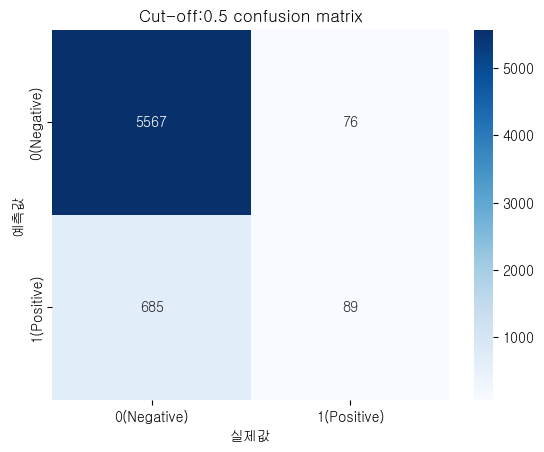

True Positive:89
True Negative:5567
False Positive:76
False Negative:685


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,11.498708,9.251285,13.746132
1,Specificity,98.653199,98.352447,98.953951
2,Accuracy,88.140876,87.349824,88.931928
3,PPV,53.939394,46.333821,61.544967
4,NPV,89.043506,88.269252,89.817760
5,F_1_score,9.478168,NaN,NaN


In [17]:
# cut-off 0.5
cm = confusion_matrix(result['TARGET1'], result['prob_5'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.5 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(result[(result['prob_5']==1)&(result['TARGET1']==1)])}")
print(f"True Negative:{len(result[(result['prob_5']==0)&(result['TARGET1']==0)])}")
print(f"False Positive:{len(result[(result['prob_5']==1)&(result['TARGET1']==0)])}")
print(f"False Negative:{len(result[(result['prob_5']==0)&(result['TARGET1']==1)])}")

performance(TP=89,TN=5567,FP=76,FN=685,BETA=1)

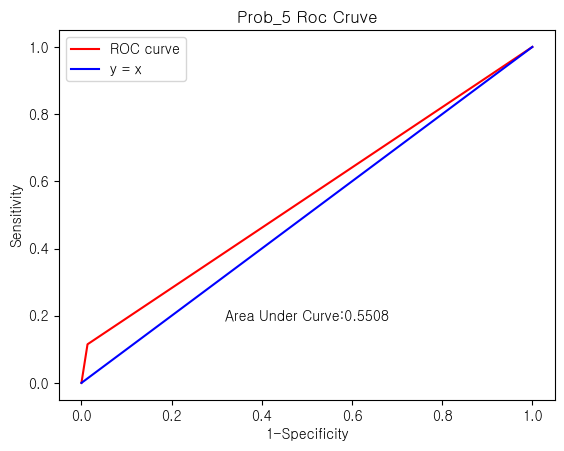

In [18]:
# roc curve, auc
fpr, tpr, thresholds = roc_curve(result['TARGET1'], result['prob_5'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(result['TARGET1'], result['prob_5'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Prob_5 Roc Cruve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

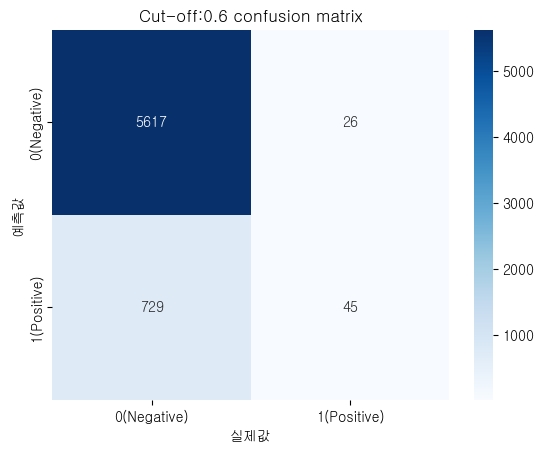

True Positive:45
True Negative:5617
False Positive:26
False Negative:729


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,5.813953,4.165356,7.462551
1,Specificity,99.539252,99.362555,99.715949
2,Accuracy,88.234377,87.446032,89.022723
3,PPV,63.380282,52.174001,74.586562
4,NPV,88.512449,87.727896,89.297001
5,F_1_score,5.325444,NaN,NaN


In [19]:
# cut-off 0.6
cm = confusion_matrix(result['TARGET1'], result['prob_6'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.6 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(result[(result['prob_6']==1)&(result['TARGET1']==1)])}")
print(f"True Negative:{len(result[(result['prob_6']==0)&(result['TARGET1']==0)])}")
print(f"False Positive:{len(result[(result['prob_6']==1)&(result['TARGET1']==0)])}")
print(f"False Negative:{len(result[(result['prob_6']==0)&(result['TARGET1']==1)])}")

performance(TP=45,TN=5617,FP=26,FN=729,BETA=1)

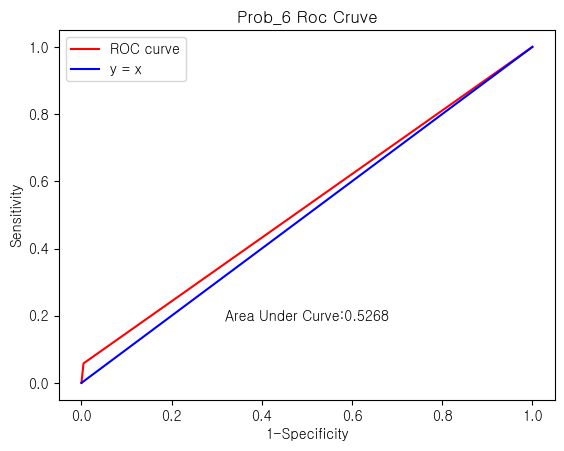

In [20]:
# roc curve, auc
fpr, tpr, thresholds = roc_curve(result['TARGET1'], result['prob_6'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(result['TARGET1'], result['prob_6'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Prob_6 Roc Cruve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

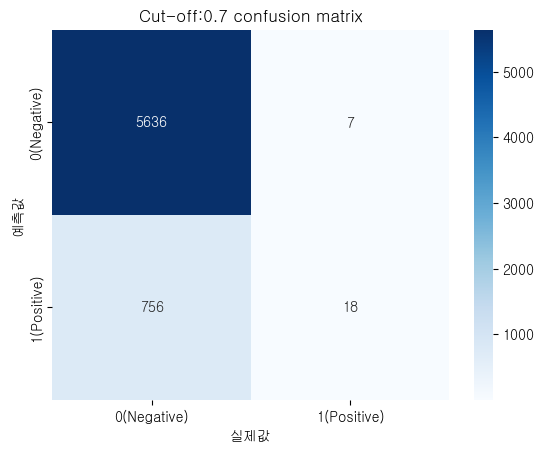

True Positive:18
True Negative:5636
False Positive:7
False Negative:756


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,2.325581,1.263784,3.387379
1,Specificity,99.875953,99.784114,99.967791
2,Accuracy,88.109709,87.317758,88.901659
3,PPV,72.000000,54.399244,89.600756
4,NPV,88.172716,87.381040,88.964392
5,F_1_score,2.252816,NaN,NaN


In [21]:
# cut-off 0.7
cm = confusion_matrix(result['TARGET1'], result['prob_7'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.7 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(result[(result['prob_7']==1)&(result['TARGET1']==1)])}")
print(f"True Negative:{len(result[(result['prob_7']==0)&(result['TARGET1']==0)])}")
print(f"False Positive:{len(result[(result['prob_7']==1)&(result['TARGET1']==0)])}")
print(f"False Negative:{len(result[(result['prob_7']==0)&(result['TARGET1']==1)])}")

performance(TP=18,TN=5636,FP=7,FN=756,BETA=1)

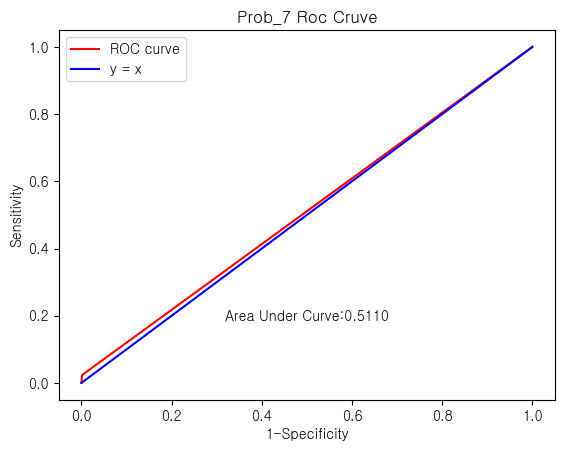

In [22]:
# roc curve, auc
fpr, tpr, thresholds = roc_curve(result['TARGET1'], result['prob_7'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(result['TARGET1'], result['prob_7'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Prob_7 Roc Cruve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

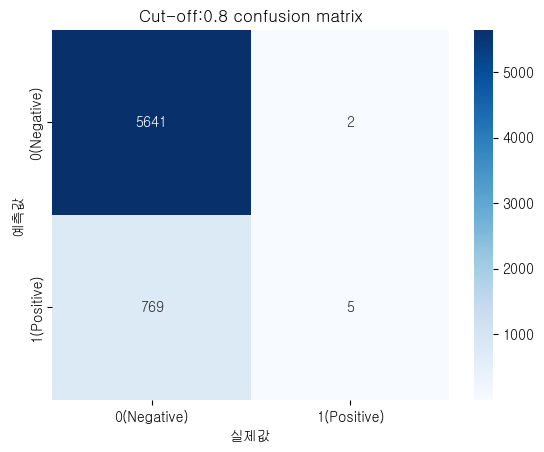

True Positive:5
True Negative:5641
False Positive:2
False Negative:769


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,0.645995,0.081587,1.210402
1,Specificity,99.964558,99.915446,100.013669
2,Accuracy,87.985040,87.189511,88.780568
3,PPV,71.428571,37.962170,104.894972
4,NPV,88.003120,87.207675,88.798565
5,F_1_score,0.640205,NaN,NaN


In [23]:
# cut-off 0.8
cm = confusion_matrix(result['TARGET1'], result['prob_8'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.8 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(result[(result['prob_8']==1)&(result['TARGET1']==1)])}")
print(f"True Negative:{len(result[(result['prob_8']==0)&(result['TARGET1']==0)])}")
print(f"False Positive:{len(result[(result['prob_8']==1)&(result['TARGET1']==0)])}")
print(f"False Negative:{len(result[(result['prob_8']==0)&(result['TARGET1']==1)])}")

performance(TP=5,TN=5641,FP=2,FN=769,BETA=1)

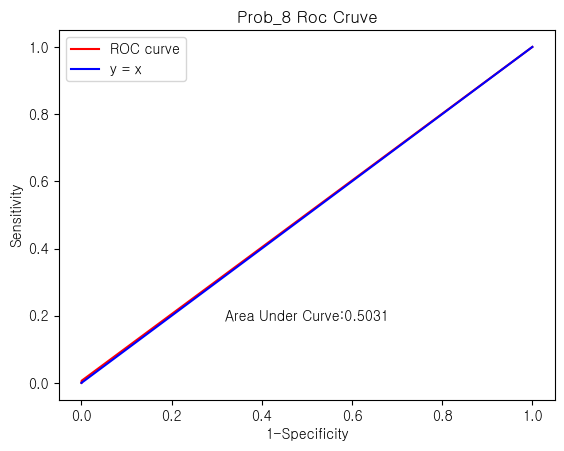

In [24]:
# roc curve, auc
fpr, tpr, thresholds = roc_curve(result['TARGET1'], result['prob_8'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(result['TARGET1'], result['prob_8'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Prob_8 Roc Cruve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

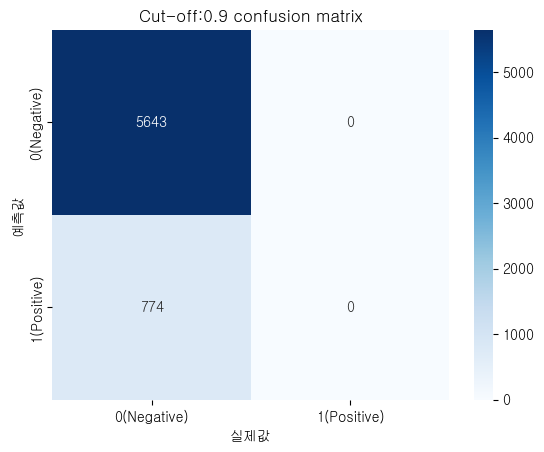

True Positive:0
True Negative:5643
False Positive:0
False Negative:774


In [25]:
# cut-off 0.9
cm = confusion_matrix(result['TARGET1'], result['prob_9'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.9 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(result[(result['prob_9']==1)&(result['TARGET1']==1)])}")
print(f"True Negative:{len(result[(result['prob_9']==0)&(result['TARGET1']==0)])}")
print(f"False Positive:{len(result[(result['prob_9']==1)&(result['TARGET1']==0)])}")
print(f"False Negative:{len(result[(result['prob_9']==0)&(result['TARGET1']==1)])}")

# performance(TP=0,TN=5643,FP=0,FN=774,BETA=1)

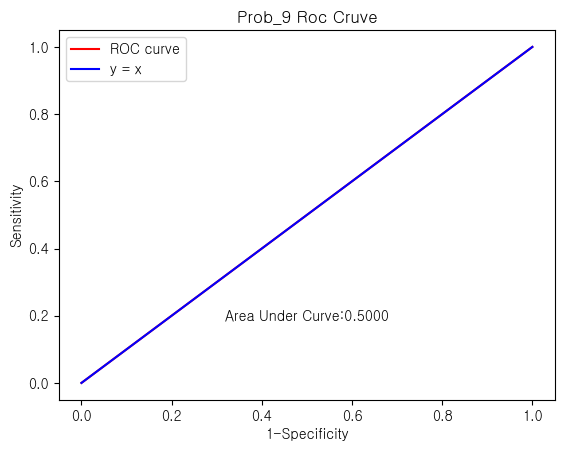

In [26]:
# roc curve, auc
fpr, tpr, thresholds = roc_curve(result['TARGET1'], result['prob_9'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(result['TARGET1'], result['prob_9'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Prob_9 Roc Cruve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [27]:
print(train['출산여부_6개월내'].unique())
print(test['출산여부_6개월내'].unique())
print(train['농가구분'].unique())
print(test['농가구분'].unique())

['Y' 'N']
['N' 'Y']
['농가소' '우시장소']
['농가소' '우시장소']


In [30]:
# 더미변수 만들기
test2 = test.copy()

result['출산Y'] = result['출산여부_6개월내'].apply(lambda x: 1 if 'Y' else 0)
result['출산N'] = result['출산여부_6개월내'].apply(lambda x: 1 if 'N' else 0)
result['농가소'] = result['농가구분'].apply(lambda x: 1 if '농가소' else 0)
result['우시장소'] = result['농가구분'].apply(lambda x: 1 if '우시장소' else 0)

In [31]:
# 수식으로 prediction
for index, row in result.iterrows():
    x = (0.005798 + (1.001965*row['개월령'])
         + (1.00126*row['생시체중']) + (1.190818*row['근내평균'])
         + (2.193519*(row['도체범위근내평균']))
         + (0.968847*row['체고'])
         + (1.02079*row['체장'])
         + (0.984163*row['형매도축수'])
         + (0.996465*row['형매도체평균'])
         + (1.125948*row['형매근내평균'])
         + (1.18409*row['형매근내평균가산'])
         + (0.957963*row['농가근내평균'])
         + (1.583727*row['농가근내평균가산'])
         + (2.124442*row['근내EPD'])
         + (0.679257*row['출산Y'])
         + (0.567428*row['농가소']))
    probability = np.exp(x) / (1 + np.exp(x))
    result.loc[index, 'Probability'] = probability

# 결과 출력
# 도축개월 조정 확률계산기를 이용해 Probability가 일치함을 확인
result.tail()

,개월령,생시체중,근내평균,도체범위근내평균,체고,체장,형매도축수,형매도체평균,형매근내평균,형매근내평균가산,...,prob_5,prob_6,prob_7,prob_8,prob_9,출산Y,출산N,농가소,우시장소,Probability
74029,51,628.57,4.64,5.33,131.7,151.4,4.0,371.25,2.50,-1.19,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,NaN
26411,46,660.71,4.71,4.87,129.4,148.4,5.0,439.60,5.80,0.93,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,NaN
15095,51,750.00,5.76,6.13,131.6,156.4,2.0,361.00,5.50,1.54,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,NaN
72433,59,553.57,5.26,6.00,131.8,147.8,7.0,387.86,5.14,0.37,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,NaN
15791,47,816.07,3.38,5.30,131.4,158.9,6.0,379.00,6.50,1.30,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,NaN
